# Há algum gargalo?

##  Sim, existem dois problemas principais, sendo eles: 
### 1- Faturas não carregadas;
#### Enquanto 13.6% das Faturas Carregadas são homologadas apeas 1.5% das Faturas Não Carregadas são homologadas. Indicando que quanto maior o número de faturas não carregadas menos será a taxa de conversão
### 2- Leads Aprovados que não tiveram propostas enviadas.
####  A taxa de conversão de Leads que a proposta é enviada é de  30.7%, enquando das não enviadas é de 3%.

# Relatório final dos principais gargalos para o aumento de conversão

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Tratando a base

In [2]:
df = pd.read_excel("C:/Users/rayne/Downloads/df_case_ANALISTA_DE_DADOS_ROBERTO.xlsx", decimal= ',')
df['mes'] = df['lead_in'].dt.month
# df['mes_de_upload_da_conta'] = df['bill_uploaded'].dt.month
# df['mes_de_aprovação_elegivel'] = df['lead_approved_eligible'].dt.month

In [3]:
print("Valores Faltantes: ", df.isnull().sum())

Valores Faltantes:  id                              0
lead_in                         0
bill_uploaded                2271
lead_approved_eligible       4756
proposal_sent                5409
proposal_opened              5515
contract_created             6169
contract_signed              6284
homologation_date            6433
lost_date                    1091
stage                           0
vendedor                     4437
lostReason                   1094
utmSource                       0
utmMedium                       0
utmCampaign                     0
utm_cidade                   2592
state                           1
billCity                     3419
proposalPercentageEconomy    4284
proposalOfferCapacity        4280
final_value                     0
billDocumentType                0
mes                             0
dtype: int64


## Replicando o funil do case

In [4]:
tabela_funil = df.groupby(['mes'],as_index = False)[['lead_in','bill_uploaded', 'lead_approved_eligible',
       'proposal_sent','contract_signed', 'homologation_date']].count()
tabela_funil

,mes,lead_in,bill_uploaded,lead_approved_eligible,proposal_sent,contract_signed,homologation_date
0,1,175,79,72,70,22,19
1,2,116,56,52,51,13,8
2,3,748,452,205,177,72,65
3,4,899,475,215,190,78,62
4,5,1303,879,376,338,126,99
5,6,1443,918,451,304,119,91
6,7,555,369,260,110,76,62
7,8,1889,1629,741,479,338,289


### Criando colunas que serão utilizadas nas análises

In [5]:
## Não se conseguiu extrair informações confiáveis dos dados de UTM e Bill City, mas caso fosse ser feita os passos abaixo seriam
## realizados

##### Tratar Strings - Letras maiusculas e minusculas
## dict city - usar a coluna utmCampaign para criar um dicionário combinado com a coluna utm_cidade par asaber a origem do utm
## na medida do possível, combinar o resultado com a coluna billCity para completar os valores vazios

In [6]:
df_analise = pd.DataFrame(df)

df_analise['mes'] = df_analise['lead_in'].dt.month
my_dict = {1:"Janeiro", 2: "Fevereiro",3:"Março",4:"Abril",5:"Maio",6:"Junho",7:"Julho",8:"Agosto",9:"Setembto",10:"Outubro",
           11:"Novembro",12:"Dezembro"}
df_analise['mes_por_extenso']= df_analise['mes'].map(my_dict)

## Adicionando algumas colunas que serão utilizadas na análise 

df_analise['fatura_carregada'] = None
for i in range(len(df_analise)):
    if pd.isna(df_analise['bill_uploaded'][i]):
        df_analise.loc[0:,'fatura_carregada'][i] = 'Fatura não carregada'
    else:
        df_analise.loc[0:,'fatura_carregada'][i] = 'Fatura carregada'
        
df_analise['conversao'] = None
for i in range(len(df_analise)):
    if pd.isna(df_analise['lost_date'][i]):
        df_analise.loc[0:,'conversao'][i] = 1
    else:
        df_analise.loc[0:,'conversao'][i] = 0

df_analise['elegivel'] = None
for i in range(len(df_analise)):
    if pd.isna(df_analise['lead_approved_eligible'][i]):
        df_analise.loc[0:,'elegivel'][i] = 'Não Elegível'
    else:
        df_analise.loc[0:,'elegivel'][i] = 'Elegível' 

df_analise['proposta_enviada'] = None
for i in range(len(df_analise)):
    if pd.isna(df_analise['proposal_sent'][i]):
        df_analise.loc[0:,'proposta_enviada'][i] = 'Proposta Não Enviada'
    else:
        df_analise.loc[0:,'proposta_enviada'][i] = 'Proposta Enviada' 
        
df_analise['homologado'] = None
for i in range(len(df_analise)):
    if pd.isna(df_analise['homologation_date'][i]):
        df_analise.loc[0:,'homologado'][i] = 0
    else:
        df_analise.loc[0:,'homologado'][i] = 1                           

##### de onde o usuário chegou
fonte_utm = ['Ambev','Facebook','site','iFood']
utm_source_top4 = df_analise.query('utmSource in @fonte_utm')

df_analise['utmSource_Top4'] = utm_source_top4['utmSource']

z =pd.get_dummies(utm_source_top4['utmSource'])
df_analise=pd.concat([z,df_analise],axis = 1)                 

a =pd.get_dummies(df_analise['billDocumentType'])
df_analise=pd.concat([a,df_analise],axis = 1) 

### Estágio Atual do Lead

etapa_lead = ['leadAnalyzed','leadCreated']  

etapa_lead_top2 = df_analise.query('stage in @etapa_lead')

df_analise['etapa_lead_top2'] = etapa_lead_top2['stage']        


df_analise

,pessoa física,pessoa jurídica,Ambev,Facebook,iFood,site,id,lead_in,bill_uploaded,lead_approved_eligible,...,billDocumentType,mes,mes_por_extenso,fatura_carregada,conversao,elegivel,proposta_enviada,homologado,utmSource_Top4,etapa_lead_top2
0,1,0,1.0,0.0,0.0,0.0,10725,2021-01-03,2021-01-08,NaT,...,pessoa física,1,Janeiro,Fatura carregada,0,Não Elegível,Proposta Não Enviada,0,Ambev,leadAnalyzed
1,1,0,1.0,0.0,0.0,0.0,10726,2021-01-04,NaT,NaT,...,pessoa física,1,Janeiro,Fatura não carregada,0,Não Elegível,Proposta Não Enviada,0,Ambev,leadAnalyzed
2,0,1,1.0,0.0,0.0,0.0,10727,2021-01-04,2021-01-04,NaT,...,pessoa jurídica,1,Janeiro,Fatura carregada,0,Não Elegível,Proposta Não Enviada,0,Ambev,leadAnalyzed
3,1,0,1.0,0.0,0.0,0.0,10728,2021-01-04,NaT,2021-01-04,...,pessoa física,1,Janeiro,Fatura não carregada,0,Elegível,Proposta Enviada,0,Ambev,NaN
4,1,0,1.0,0.0,0.0,0.0,10729,2021-01-04,NaT,2021-01-04,...,pessoa física,1,Janeiro,Fatura não carregada,0,Elegível,Proposta Enviada,0,Ambev,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7047,1,0,NaN,NaN,NaN,NaN,18024,2021-08-30,NaT,NaT,...,pessoa física,8,Agosto,Fatura não carregada,1,Não Elegível,Proposta Não Enviada,0,NaN,leadCreated
7073,1,0,NaN,NaN,NaN,NaN,18050,2021-08-31,NaT,NaT,...,pessoa física,8,Agosto,Fatura não carregada,0,Não Elegível,Proposta Não Enviada,0,NaN,leadCreated
7074,0,1,NaN,NaN,NaN,NaN,18051,2021-08-31,NaT,NaT,...,pessoa jurídica,8,Agosto,Fatura não carregada,0,Não Elegível,Proposta Não Enviada,0,NaN,leadCreated
7099,1,0,NaN,NaN,NaN,NaN,18076,2021-08-31,2021-08-31,NaT,...,pessoa física,8,Agosto,Fatura carregada,0,Não Elegível,Proposta Não Enviada,0,NaN,leadAnalyzed


# Quais são os principais motivos de perda?

In [7]:
df_analise.where(df_analise['homologado']==0)['lostReason'].value_counts()

Consumo muito baixo                      1932
Não houve contato                        1296
Card Duplicado                            712
Sem interesse                             490
Está com o Concorrente                    247
Investiu em painéis                       236
Troca de titularidade - Em negociação     203
Fora área de atendimento                  176
Inadimplente na Disco                     164
Recebe benefício tributário                80
PDV sem CNPJ                               64
Tarifa Rural                               58
CNPJ Irregular                             41
Empresa Faliu                              29
Troca de titularidade - já assinado        27
Alta tensão                                23
Número inválido - Sem contato              22
Esperava economia maior                    20
CNPJ irregular                             12
Lista de Espera Cooperativa                12
Documento Irregular [CX]                   12
Mudança de endereço               

In [8]:
lost_labels = df_analise['lostReason'].value_counts().index.tolist()

# Utilizando as labels com maior volumetria de dados e categorizando as demais como outros.
lost_labels = [lost_labels[0], lost_labels[1], lost_labels[2],lost_labels[3]]
lost_labels

['Consumo muito baixo', 'Não houve contato', 'Card Duplicado', 'Sem interesse']

In [9]:
df_analise.loc[~df_analise['lostReason'].isin(lost_labels), 'lostReason'] = 'Outros'

### Perda de Lead por motivo
df_analise.where(df_analise['homologado']==0)['lostReason'].value_counts()

Outros                 2003
Consumo muito baixo    1932
Não houve contato      1296
Card Duplicado          712
Sem interesse           490
Name: lostReason, dtype: int64

In [10]:
lost_tot = df_analise.where(df_analise['homologado']==0)['lostReason'].value_counts().values

lost_percet = [100*x/lost_tot.sum() for x in lost_tot]
lost_percet

[31.136328307166174,
 30.03264417845484,
 20.14612156070263,
 11.067930980879838,
 7.616974972796518]

In [11]:
labels = df_analise.where(df_analise['homologado']==0)['lostReason'].value_counts().index.tolist()
lost_values = df_analise.where(df_analise['homologado']==0)['lostReason'].value_counts().values
lost_values = [lost_values[0], lost_values[1], lost_values[2], lost_values[3], lost_values[4]]
lost_values

[2003, 1932, 1296, 712, 490]

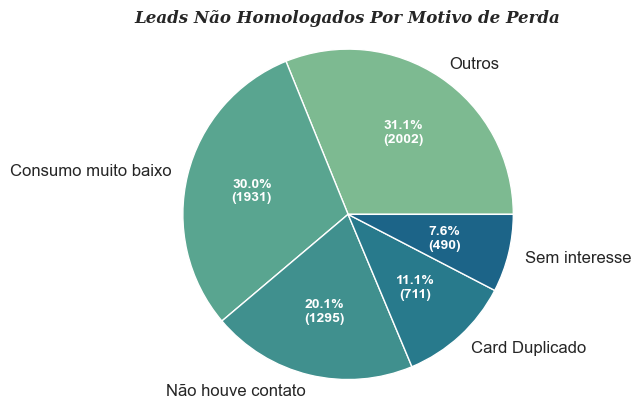

In [69]:
fig1, ax1 = plt.subplots()

sns.set_palette('crest')

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


_, _, autopcts = ax1.pie(lost_values, labels=labels, autopct=lambda pct: func(pct, lost_values))


plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':10})

ax1.set_title('Leads Não Homologados Por Motivo de Perda',fontsize = 12, fontweight ='bold',
              fontstyle ='italic',fontfamily ='serif')
ax1.axis('equal')

plt.show()

# Onde estão os principais motivos de perda?

## O fato da fatura não ser carregada pode acaretar em um aumeto da quatidade de Leads Não Homologados?
### Sim, dado que enquanto 13.6% das Faturas Carregadas são homologadas apenas 1.5% das Faturas Não Carregadas são homologadas.

In [13]:
## Motivo de perda por Fatura

df_analise.where(df_analise['homologado']==0).groupby(['fatura_carregada', 'lostReason']).size().reset_index()\
.pivot(columns='fatura_carregada',index='lostReason', values=0)

fatura_carregada,Fatura carregada,Fatura não carregada
lostReason,,
Card Duplicado,283,429
Consumo muito baixo,1822,110
Não houve contato,302,994
Outros,1447,556
Sem interesse,343,147


In [14]:
df_analise.groupby(['fatura_carregada', 'homologado']).size().reset_index()\
.pivot(columns='fatura_carregada',index='homologado', values=0)

fatura_carregada,Fatura carregada,Fatura não carregada
homologado,,
0,4197,2236
1,660,35


In [15]:
fat_upload = df_analise.where(df_analise['fatura_carregada']=='Fatura carregada')['homologado'].value_counts()

percent_homologado_fat_upload = [100*x/fat_upload.sum() for x in fat_upload]
percent_homologado_fat_upload

[86.41136504014824, 13.58863495985176]

In [16]:
labels_carg = ['Não Homologado','Homologado']
values_fat_carregada = df_analise.where(df_analise['fatura_carregada']=='Fatura carregada')['homologado'].value_counts().values
values_fat_carregada = [values_fat_carregada[0], values_fat_carregada[1]]
values_fat_carregada

[4197, 660]

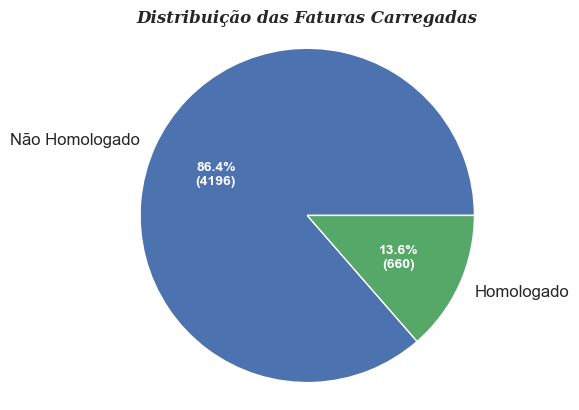

In [86]:
fig1, ax1 = plt.subplots()


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


_, _, autopcts = ax1.pie(values_fat_carregada,labels = labels_carg, autopct=lambda pct: func(pct, values_fat_carregada), 
                         colors =['#4c72b0', '#55a868'])


plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':10})

ax1.set_title('Distribuição das Faturas Carregadas',fontsize = 12, fontweight ='bold',
              fontstyle ='italic',fontfamily ='serif')
ax1.axis('equal')

plt.show()

In [18]:
fat_n_upload = df_analise.where(df_analise['fatura_carregada']=='Fatura não carregada')['homologado'].value_counts()

percent_homologado_fat_n_upload = [100*x/fat_n_upload.sum() for x in fat_n_upload]
percent_homologado_fat_n_upload

[98.45882870981946, 1.5411712901805372]

In [19]:
labels_carg = ['Não Homologado','Homologado']
values_fat_n_carregada = df_analise.where(df_analise['fatura_carregada']=='Fatura não carregada')['homologado']\
.value_counts().values
values_fat_n_carregada = [values_fat_n_carregada[0], values_fat_n_carregada[1]]
values_fat_n_carregada

[2236, 35]

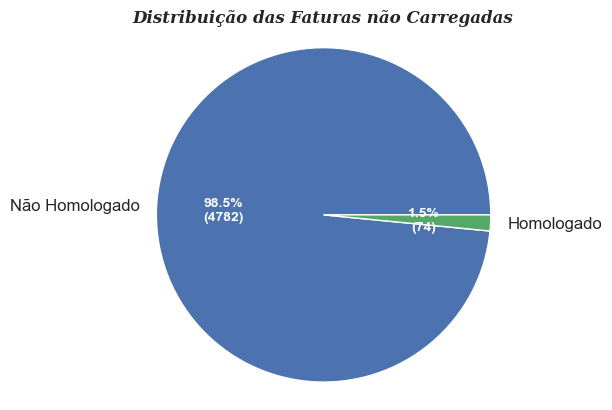

In [85]:
fig1, ax1 = plt.subplots()


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


_, _, autopcts = ax1.pie(values_fat_n_carregada,labels = labels_carg, autopct=lambda pct: func(pct, values_fat_carregada), 
                         colors =['#4c72b0', '#55a868'])


plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':10})

ax1.set_title('Distribuição das Faturas não Carregadas',fontsize = 12, fontweight ='bold',
              fontstyle ='italic',fontfamily ='serif')
ax1.axis('equal')

plt.show()

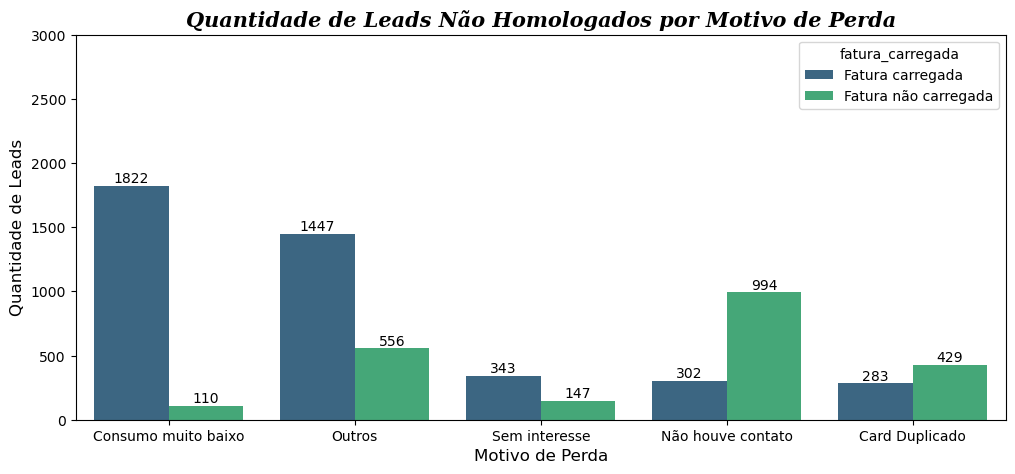

In [21]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['fatura_carregada'])\
[['lostReason']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_motivo_perda = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="lostReason", y="quantidade_de_leads",hue='fatura_carregada', data=n_homologado_motivo_perda,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,3000])
ax.set_title('Quantidade de Leads Não Homologados por Motivo de Perda',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Motivo de Perda',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)

In [22]:
# Motivo de perda por Elegibilidade

df_analise.where(df_analise['homologado']==0).groupby(['elegivel', 'lostReason']).size().reset_index()\
.pivot(columns='elegivel',index='lostReason', values=0)

elegivel,Elegível,Não Elegível
lostReason,,
Card Duplicado,176,536
Consumo muito baixo,62,1870
Não houve contato,220,1076
Outros,856,1147
Sem interesse,363,127


# O fato da proposta não ser enviada pode acaretar em um aumeto da quatidade de Leads Não Homologados?
# - Sim, uma vez que a taxa de conversão de Leads que a proposta é enviada é de  30.7%, enquando das não enviadas é de 3%
## Existem Leads aprovados que a proposta não foi enviada?
###  - Sim, existem 491 Leads Elegíveis que a Proposta não foi enviada
## Quais os motivos de perda desses Leads?
### - Os motivos principais são: Cards Duplicados e Outros

In [23]:
df_analise.where(df_analise['proposta_enviada']=='Proposta Enviada')\
.groupby(['proposta_enviada','homologado']).size().reset_index()\
.pivot(columns='proposta_enviada',index='homologado', values=0)

proposta_enviada,Proposta Enviada
homologado,
0,1191
1,528


In [24]:
prop_enviada = df_analise.where(df_analise['proposta_enviada']=='Proposta Enviada')['homologado'].value_counts()

percent_homologado_pro_enviada = [100*x/prop_enviada.sum() for x in prop_enviada]
percent_homologado_pro_enviada

[69.28446771378708, 30.715532286212916]

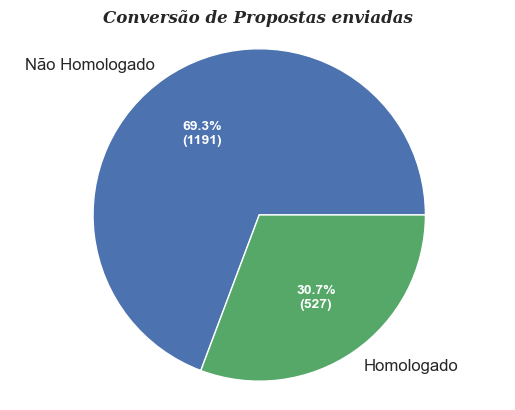

In [72]:
labels_proposta = ['Não Homologado','Homologado']

values_proposta = df_analise.where(df_analise['proposta_enviada']=='Proposta Enviada')['homologado'].value_counts()\
.values
values_proposta = [values_proposta[0], values_proposta[1]]


fig1, ax1 = plt.subplots()


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


_, _, autopcts = ax1.pie(values_proposta,labels = labels_proposta, 
                         autopct=lambda pct: func(pct, values_proposta), 
                         colors =['#4c72b0', '#55a868'])


plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':10})

ax1.set_title('Conversão de Propostas enviadas',fontsize = 12, fontweight ='bold',
              fontstyle ='italic',fontfamily ='serif')
ax1.axis('equal')

plt.show()

In [26]:
df_analise.where(df_analise['proposta_enviada']=='Proposta Não Enviada')\
.groupby(['proposta_enviada','homologado']).size().reset_index()\
.pivot(columns='proposta_enviada',index='homologado', values=0)

proposta_enviada,Proposta Não Enviada
homologado,
0,5242
1,167


In [27]:
prop_n_enviada = df_analise.where(df_analise['proposta_enviada']=='Proposta Não Enviada')['homologado'].value_counts()

percent_homologado_prop_n_enviada = [100*x/prop_n_enviada.sum() for x in prop_n_enviada]
percent_homologado_prop_n_enviada

[96.91255315215382, 3.0874468478461825]

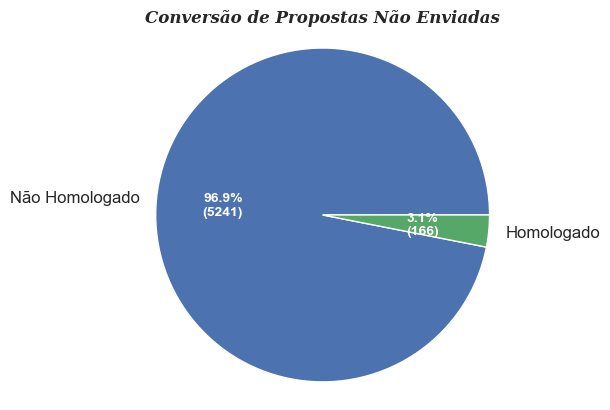

In [87]:
labels_proposta_n_enviada = ['Não Homologado','Homologado']

values_proposta_n_enviada = df_analise.where(df_analise['proposta_enviada']=='Proposta Não Enviada')['homologado']\
.value_counts().values

values_proposta = [values_proposta_n_enviada[0], values_proposta_n_enviada[1]]


fig1, ax1 = plt.subplots()


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


_, _, autopcts = ax1.pie(values_proposta_n_enviada,labels = labels_proposta_n_enviada, 
                         autopct=lambda pct: func(pct, values_proposta_n_enviada), 
                         colors =['#4c72b0', '#55a868'])


plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':10})

ax1.set_title('Conversão de Propostas Não Enviadas',fontsize = 12, fontweight ='bold',
              fontstyle ='italic',fontfamily ='serif')
ax1.axis('equal')

plt.show()

In [29]:
## Existem Leads aprovados que a proposta não foi enviada?


df_analise.where((df_analise['elegivel']=='Elegível') &(df_analise['homologado']==0))\
.groupby(['proposta_enviada','homologado']).size().reset_index()\
.pivot(columns='proposta_enviada',index='homologado', values=0)

proposta_enviada,Proposta Enviada,Proposta Não Enviada
homologado,,
0,1186,491


In [30]:
labels_elegiveis = ['Proposta Enviada','Proposta Não Enviada']

values_elegivel_proposta = df_analise.where((df_analise['elegivel']=='Elegível') &(df_analise['homologado']==0))\
.groupby(['proposta_enviada'])['homologado'].value_counts().values
values_elegivel_proposta = [values_elegivel_proposta[0], values_elegivel_proposta[1]]
values_elegivel_proposta

[1186, 491]

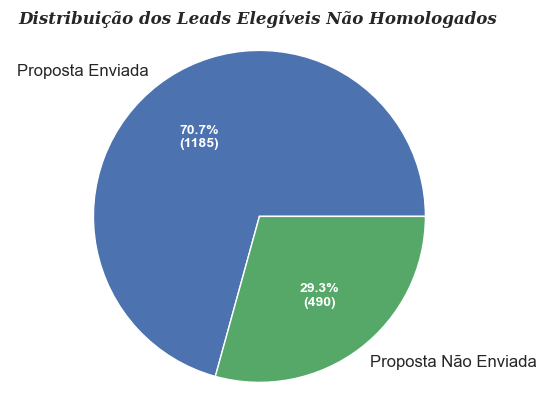

In [74]:
fig1, ax1 = plt.subplots()


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


_, _, autopcts = ax1.pie(values_elegivel_proposta,labels = labels_elegiveis, 
                         autopct=lambda pct: func(pct, values_elegivel_proposta), 
                         colors =['#4c72b0', '#55a868'])


plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':10})

ax1.set_title('Distribuição dos Leads Elegíveis Não Homologados',fontsize = 12, fontweight ='bold',
              fontstyle ='italic',fontfamily ='serif')
ax1.axis('equal')

plt.show()

In [32]:
## Motivo de perda de propostas eviadas e não eviadas
df_analise.where(df_analise['homologado']==0).groupby(['proposta_enviada', 'lostReason']).size().reset_index()\
.pivot(columns='proposta_enviada',index='lostReason', values=0)

proposta_enviada,Proposta Enviada,Proposta Não Enviada
lostReason,,
Card Duplicado,74,638
Consumo muito baixo,40,1892
Não houve contato,184,1112
Outros,585,1418
Sem interesse,308,182


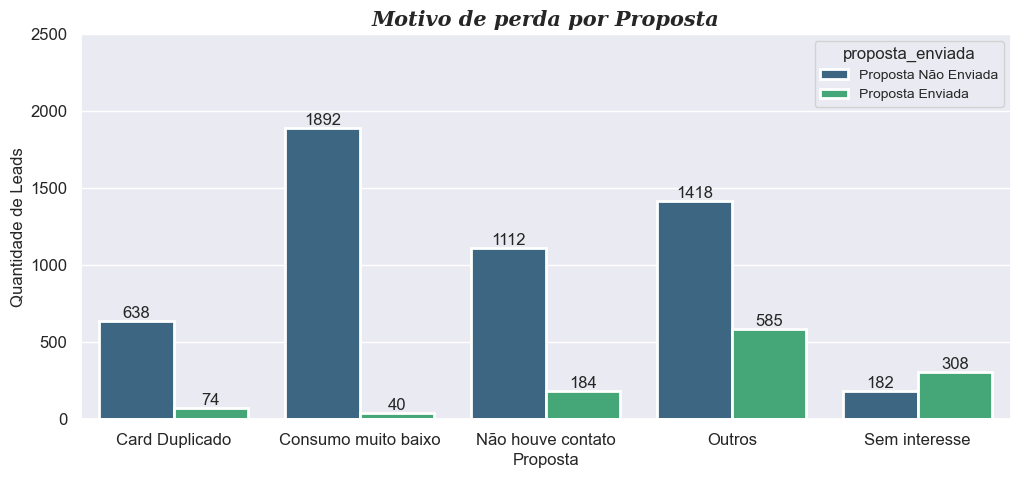

In [33]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['lostReason'])\
[['proposta_enviada']].value_counts().reset_index()

rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 10, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12}

sns.set(rc=rc)

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
homologado_por_tipo_doc = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="lostReason", y="quantidade_de_leads",hue='proposta_enviada', data=homologado_por_tipo_doc,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,2500])
ax.set_title('Motivo de perda por Proposta',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Proposta',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)

In [34]:
df_analise.where((df_analise['homologado']==0) & (df_analise['elegivel']=='Elegível'))\
.groupby(['proposta_enviada', 'lostReason']).size().reset_index()\
.pivot(columns='proposta_enviada',index='lostReason', values=0)

proposta_enviada,Proposta Enviada,Proposta Não Enviada
lostReason,,
Card Duplicado,72,104
Consumo muito baixo,40,22
Não houve contato,183,37
Outros,584,272
Sem interesse,307,56


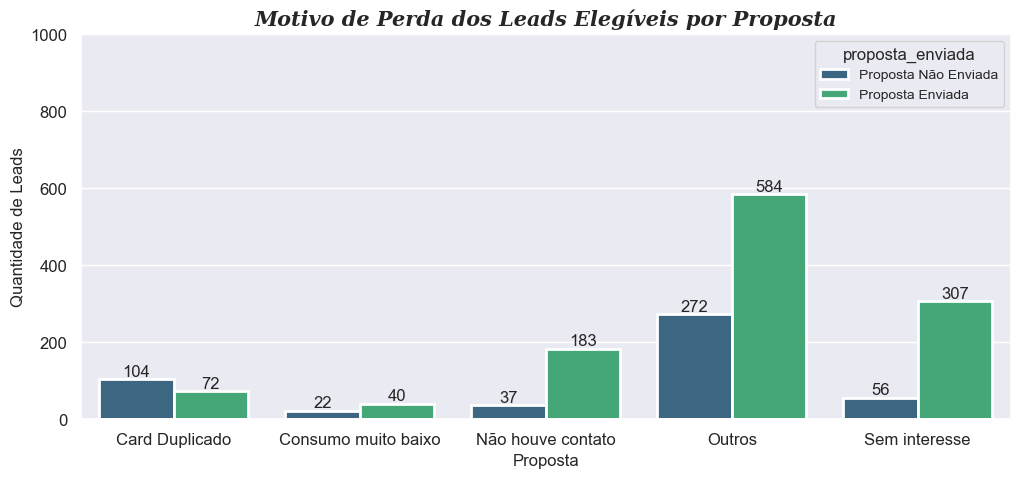

In [35]:
temp_bar = df_analise.where((df_analise['homologado']==0) & (df_analise['elegivel']=='Elegível')).groupby(['lostReason'])\
[['proposta_enviada']].value_counts().reset_index()

rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 10, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12}

sns.set(rc=rc)

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
homologado_por_tipo_doc = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="lostReason", y="quantidade_de_leads",hue='proposta_enviada', data=homologado_por_tipo_doc,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,1000])
ax.set_title('Motivo de Perda dos Leads Elegíveis por Proposta',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Proposta',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)

In [36]:
## Motivo de perda por tipo de conta

df_analise.where(df_analise['homologado']==0).groupby(['billDocumentType', 'lostReason']).size().reset_index()\
.pivot(columns='billDocumentType',index='lostReason', values=0)

billDocumentType,pessoa física,pessoa jurídica
lostReason,,
Card Duplicado,428,284
Consumo muito baixo,1610,322
Não houve contato,730,566
Outros,1241,762
Sem interesse,327,163


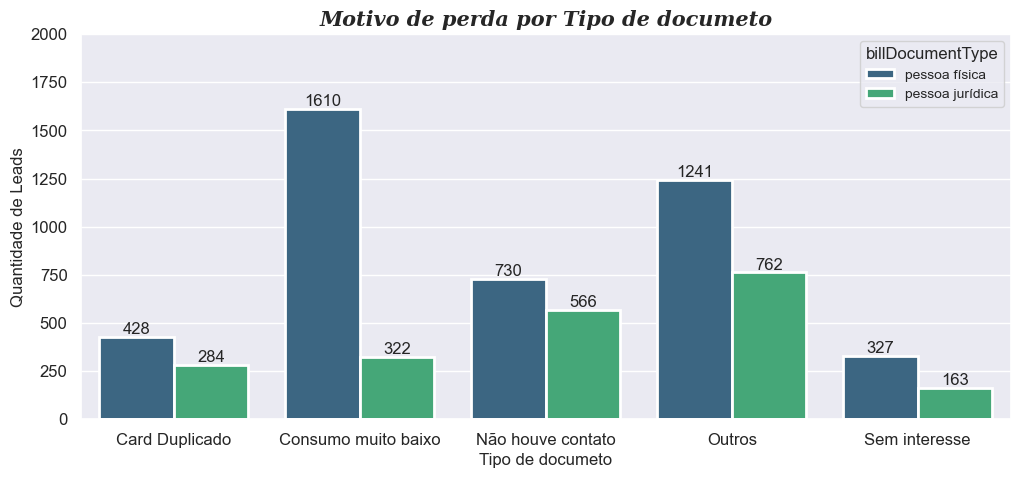

In [84]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['lostReason'])\
[['billDocumentType']].value_counts().reset_index()

rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 10, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12}

sns.set(rc=rc)

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
homologado_por_tipo_doc = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="lostReason", y="quantidade_de_leads",hue='billDocumentType', data=homologado_por_tipo_doc,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,2000])
ax.set_title('Motivo de perda por Tipo de documeto',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Tipo de documeto',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)


# Em qual Etapa o Lead está "morrendo" ?

In [38]:
stage_label = df_analise['stage'].value_counts().index.tolist()

# Utilizando as labels com maior volumetria de dados e categorizando as demais como outros.
stage_label = [stage_label[0], stage_label[1], stage_label[2],stage_label[3]]
stage_label
df_analise.loc[~df_analise['stage'].isin(stage_label), 'stage'] = 'Outros'


In [39]:
# Leads perdidos por etapa
df_analise.where(df_analise['homologado']==0)['stage'].value_counts()

leadAnalyzed              2687
leadCreated               2040
Outros                    1193
contractProposalOpened     513
Name: stage, dtype: int64

In [40]:
## Motivo de perda por Etapa

df_analise.where(df_analise['homologado']==0).groupby(['stage', 'lostReason']).size().reset_index()\
.pivot(columns='stage',index='lostReason', values=0)

stage,Outros,contractProposalOpened,leadAnalyzed,leadCreated
lostReason,,,,
Card Duplicado,107,30,174,401
Consumo muito baixo,149,18,1697,68
Não houve contato,200,72,69,955
Outros,578,251,678,496
Sem interesse,159,142,69,120


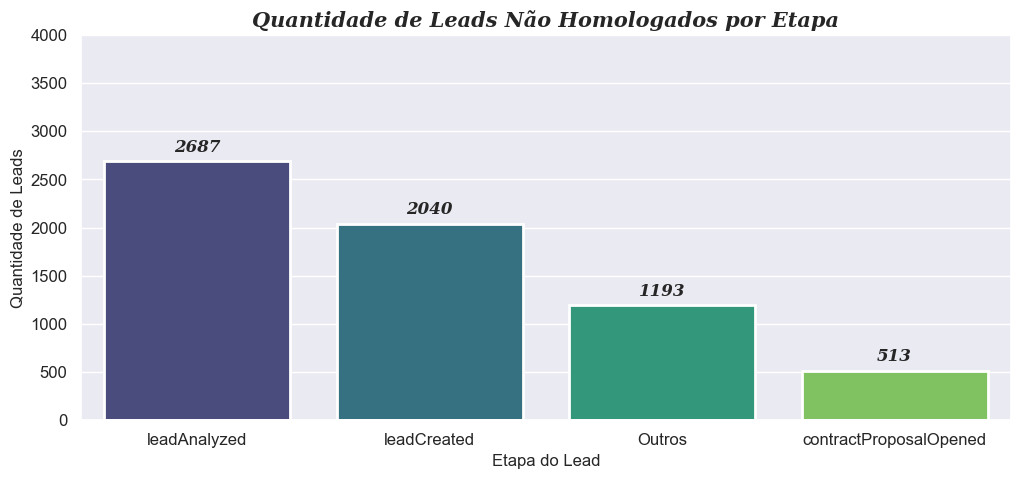

In [41]:
### Quais or principais motivos de perda dos não homologados que não importam a conta?

temp_bar = df_analise.where(df_analise['homologado']==0)[['stage']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
df = pd.DataFrame(temp_bar)

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="stage", y="quantidade_de_leads", data=df,linewidth=2, palette='viridis',ax = ax)

ax.set_ylim([0,4000])
ax.set_title('Quantidade de Leads Não Homologados por Etapa',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Etapa do Lead',fontsize= 12)

# Adicionando os valores nas colunas
for i in range(len(df)):
    plt.text(x=i, y=df['quantidade_de_leads'][i]+100, s=df['quantidade_de_leads'][i], ha='center', fontsize=12
            ,fontweight ='bold',fontstyle ='italic',fontfamily ='serif')



# O que pode estar diminuindo a taxa de conversão?

### Faturas não carregadas, em grande parte, "morrem" já na primeira etapa, que é a de criação de Lead 

### Ou seja, quanto maior a quantidade de Faturas Carregadas mais longe no funil os Leads irão

In [42]:
df_analise.groupby(['fatura_carregada', 'stage']).size().reset_index()\
.pivot(columns='fatura_carregada',index='stage', values=0).fillna(0)

fatura_carregada,Fatura carregada,Fatura não carregada
stage,,
Outros,1112,86
contractProposalOpened,474,39
dealJoinedEnergyFarm,655,35
leadAnalyzed,2615,72
leadCreated,1,2039


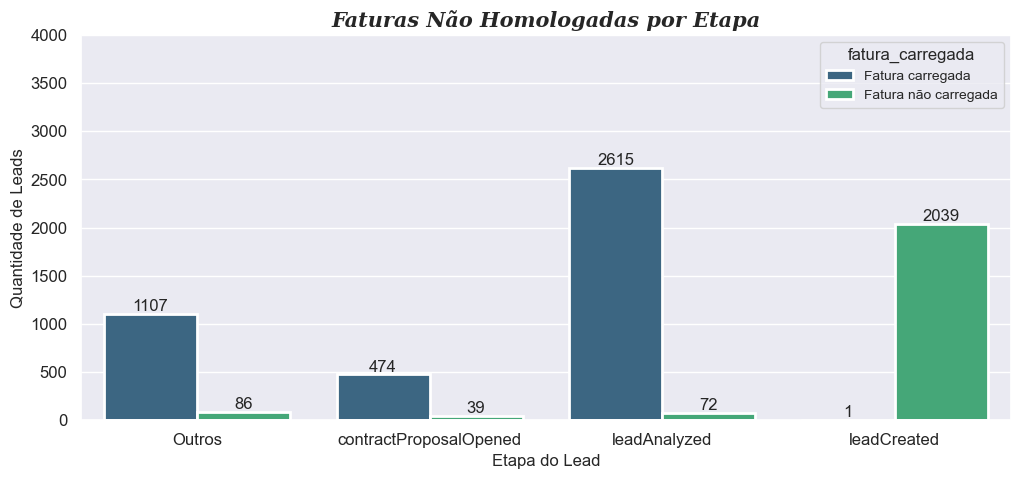

In [43]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['stage'])\
[['fatura_carregada']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_motivo_perda = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="stage", y="quantidade_de_leads",hue='fatura_carregada', data=n_homologado_motivo_perda,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,4000])
ax.set_title('Faturas Não Homologadas por Etapa',fontsize = 15, fontweight ='bold'
             ,fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Etapa do Lead',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)

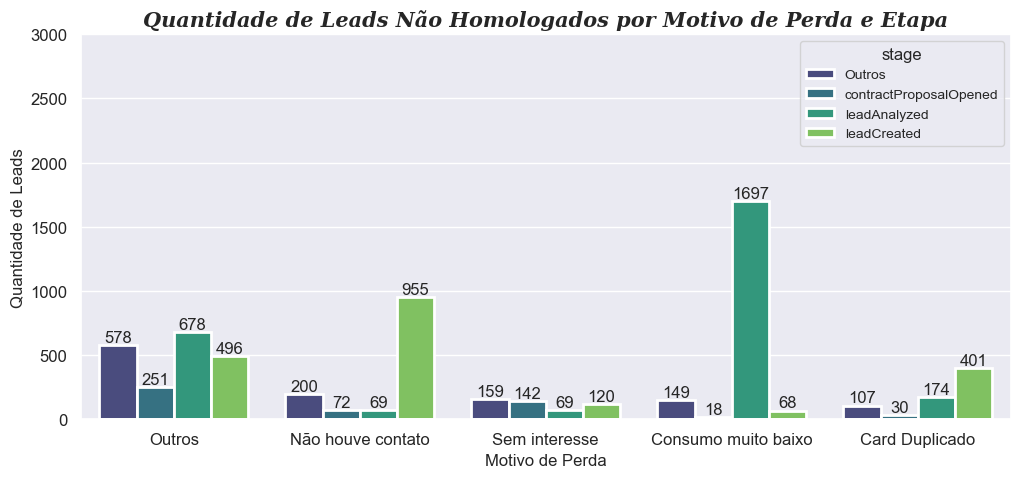

In [44]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['stage'])\
[['lostReason']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_motivo_perda = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="lostReason", y="quantidade_de_leads",hue='stage', data=n_homologado_motivo_perda,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,3000])
ax.set_title('Quantidade de Leads Não Homologados por Motivo de Perda e Etapa',fontsize = 15, fontweight ='bold'
             ,fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Motivo de Perda',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)

## Faturas carregadas x não carregadas por motivo de perda e por etapa

In [45]:
## Filtrando apeas para leads não homologados
df_analise.where((df_analise['homologado']==0)).groupby(['fatura_carregada', 'stage']).size().reset_index()\
.pivot(columns='fatura_carregada',index='stage', values=0).fillna(0)

fatura_carregada,Fatura carregada,Fatura não carregada
stage,,
Outros,1107,86
contractProposalOpened,474,39
leadAnalyzed,2615,72
leadCreated,1,2039


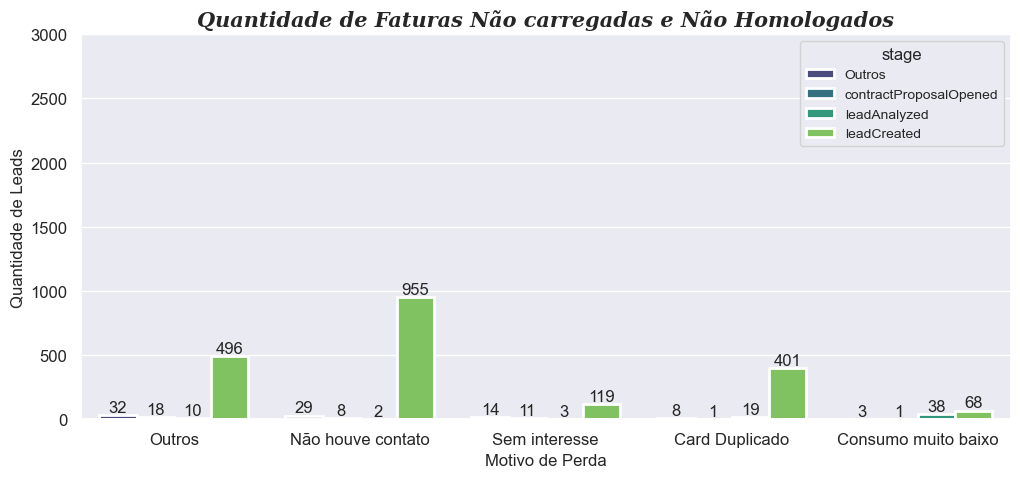

In [46]:
temp_bar = df_analise.where((df_analise['fatura_carregada']=='Fatura não carregada') & (df_analise['homologado']==0))\
.groupby(['stage'])[['lostReason']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_motivo_perda = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="lostReason", y="quantidade_de_leads",hue='stage', data=n_homologado_motivo_perda,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,3000])
ax.set_title('Quantidade de Faturas Não carregadas e Não Homologados',fontsize = 15, fontweight ='bold'
             ,fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Motivo de Perda',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)

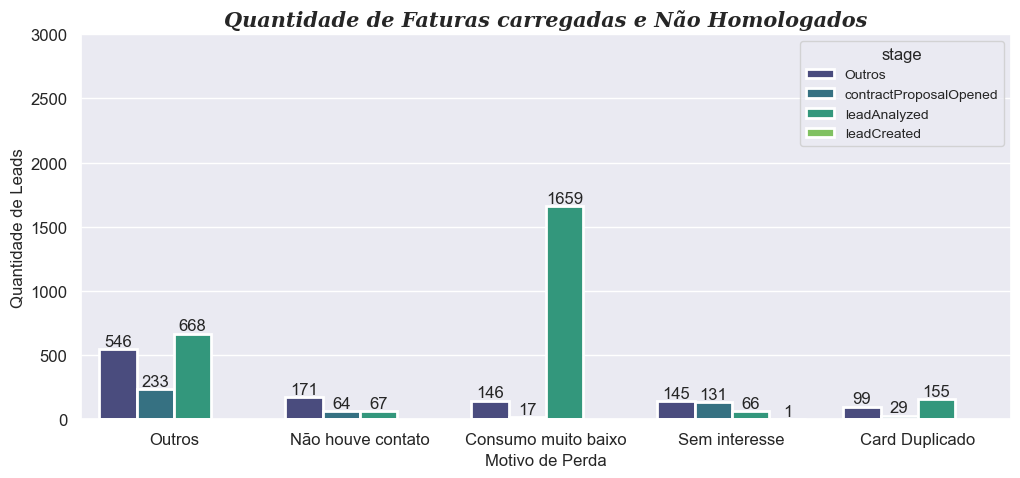

In [47]:
temp_bar = df_analise.where((df_analise['fatura_carregada']=='Fatura carregada') & (df_analise['homologado']==0))\
.groupby(['stage'])[['lostReason']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_motivo_perda = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="lostReason", y="quantidade_de_leads",hue='stage', data=n_homologado_motivo_perda,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,3000])
ax.set_title('Quantidade de Faturas carregadas e Não Homologados',fontsize = 15, fontweight ='bold'
             ,fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Motivo de Perda',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)


## Visão Temporal

In [48]:
fat_upload= df_analise.where(df_analise['homologado']==1).groupby(['mes','mes_por_extenso'],as_index = False)\
[['fatura_carregada']].value_counts()

temp_fat = df_analise.where(df_analise['homologado']==1).groupby(['mes_por_extenso'],as_index = False)\
[['homologation_date']].count()
fat_upload = pd.merge(fat_upload,temp_fat,on='mes_por_extenso', how = 'outer')

fat_upload['percent_fat_homologada'] = ((fat_upload['count']/fat_upload['homologation_date'])*100).round(2)

fat_upload

,mes,mes_por_extenso,fatura_carregada,count,homologation_date,percent_fat_homologada
0,1.0,Janeiro,Fatura carregada,13,19,68.42
1,1.0,Janeiro,Fatura não carregada,6,19,31.58
2,2.0,Fevereiro,Fatura carregada,5,8,62.50
3,2.0,Fevereiro,Fatura não carregada,3,8,37.50
4,3.0,Março,Fatura carregada,61,65,93.85
5,3.0,Março,Fatura não carregada,4,65,6.15
6,4.0,Abril,Fatura carregada,48,62,77.42
7,4.0,Abril,Fatura não carregada,14,62,22.58
8,5.0,Maio,Fatura carregada,98,99,98.99
9,5.0,Maio,Fatura não carregada,1,99,1.01


In [49]:
#### Sabendo que os dois principais Stages são Lead Analyzed e Lead Created, a análise será em cima deles

n_homologado_por_etapa = df_analise.where(df_analise['homologado']==0).groupby(['mes','mes_por_extenso'],as_index = False)\
['etapa_lead_top2'].value_counts()

temp = df_analise.groupby(['mes'],as_index = False)[['lead_in']].count()

n_homologado_por_etapa = pd.merge(temp,n_homologado_por_etapa,on='mes', how = 'outer') 
n_homologado_por_etapa['percent_lead_n_homologado'] = ((n_homologado_por_etapa['count']/n_homologado_por_etapa['lead_in'])*100)\
.round(2)

n_homologado_por_etapa

,mes,lead_in,mes_por_extenso,etapa_lead_top2,count,percent_lead_n_homologado
0,1,175,Janeiro,leadAnalyzed,49,28.00
1,1,175,Janeiro,leadCreated,40,22.86
2,2,116,Fevereiro,leadCreated,34,29.31
3,2,116,Fevereiro,leadAnalyzed,8,6.90
4,3,748,Março,leadCreated,278,37.17
5,3,748,Março,leadAnalyzed,237,31.68
6,4,899,Abril,leadCreated,390,43.38
7,4,899,Abril,leadAnalyzed,284,31.59
8,5,1303,Maio,leadAnalyzed,488,37.45
9,5,1303,Maio,leadCreated,407,31.24


In [50]:
df_taxa_de_coversao = df_analise.groupby(['mes','mes_por_extenso'],as_index = False)\
[['lead_in','bill_uploaded', 'lead_approved_eligible',
       'proposal_sent','contract_signed', 'homologation_date']].count()
df_taxa_de_coversao['coversao_percent']= ((df_taxa_de_coversao['homologation_date']/df_taxa_de_coversao['lead_in'])*100)\
.round(2)

df_taxa_de_coversao

,mes,mes_por_extenso,lead_in,bill_uploaded,lead_approved_eligible,proposal_sent,contract_signed,homologation_date,coversao_percent
0,1,Janeiro,175,79,72,70,22,19,10.86
1,2,Fevereiro,116,56,52,51,13,8,6.90
2,3,Março,748,452,205,177,72,65,8.69
3,4,Abril,899,475,215,190,78,62,6.90
4,5,Maio,1303,879,376,338,126,99,7.60
5,6,Junho,1443,918,451,304,119,91,6.31
6,7,Julho,555,369,260,110,76,62,11.17
7,8,Agosto,1889,1629,741,479,338,289,15.30


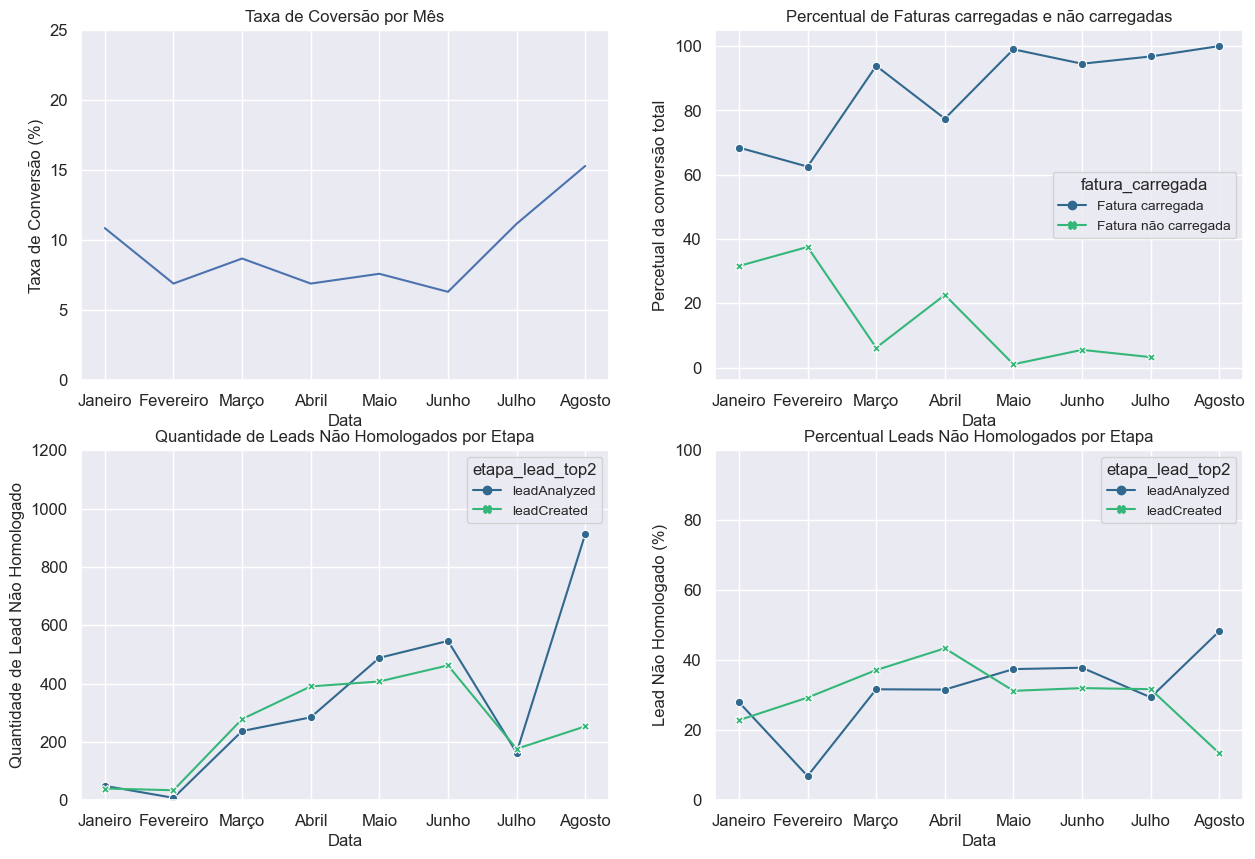

In [51]:
# Criando a figura
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# plt.style.use('ggplot')
#palette = sns.color_palette("mako_r", 2)

# Gráfico 1
sns.lineplot(data=df_taxa_de_coversao, x="mes_por_extenso", y="coversao_percent",markers=True, dashes = False, ax=axs[0,0])
axs[0,0].set_ylim([0,25])
axs[0,0].set_ylabel('Taxa de Conversão (%)')
axs[0,0].set_xlabel('Data')
# Gráfico 2

sns.lineplot(data=fat_upload, x="mes_por_extenso", y="percent_fat_homologada", hue="fatura_carregada",
             style = 'fatura_carregada',
             palette='viridis',markers=True, dashes = False, ax=axs[0,1])
axs[0,1].set_ylabel('Percetual da conversão total')
axs[0,1].set_xlabel('Data')

# Gráfico 3
sns.lineplot(data=n_homologado_por_etapa, x="mes_por_extenso", y="count", hue="etapa_lead_top2",style = 'etapa_lead_top2',
             palette='viridis',markers=True, dashes = False, ax=axs[1,0])

axs[1,0].set_ylim([0,1200])
axs[1,0].set_ylabel('Quantidade de Lead Não Homologado')
axs[1,0].set_xlabel('Data')

# Gráfico 4
sns.lineplot(data=n_homologado_por_etapa, x="mes_por_extenso", y="percent_lead_n_homologado", hue="etapa_lead_top2"
             ,style = 'etapa_lead_top2',
             palette='viridis',markers=True, dashes = False, ax=axs[1,1])
axs[1,1].set_ylim([0,100])
axs[1,1].set_ylabel('Lead Não Homologado (%)')
axs[1,1].set_xlabel('Data')

# Adicionando títulos aos gráficos
axs[0,0].set_title('Taxa de Coversão por Mês')
axs[0,1].set_title('Percentual de Faturas carregadas e não carregadas')
axs[1,0].set_title('Quantidade de Leads Não Homologados por Etapa')
axs[1,1].set_title('Percentual Leads Não Homologados por Etapa')

# Exibindo a figura
plt.show()

## Conversão por Classe (PJ X PF) e por Etapa

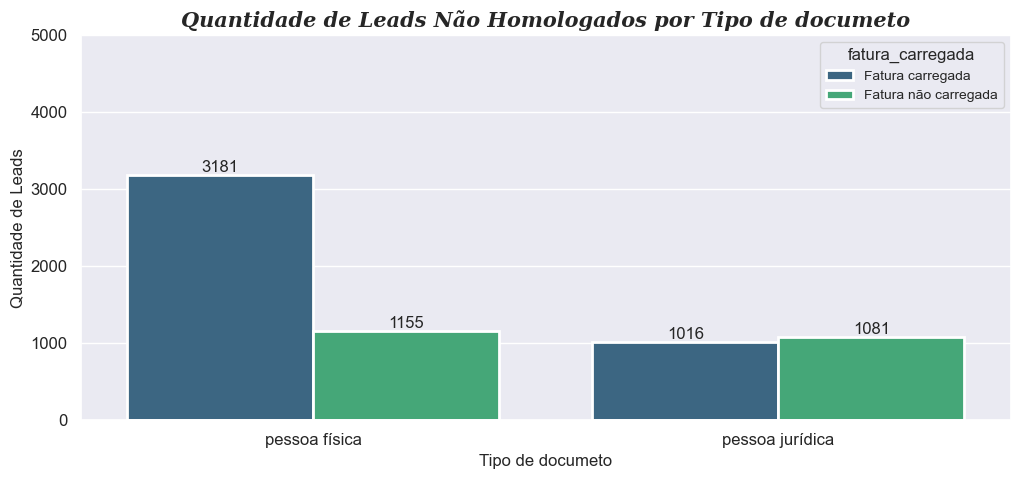

In [52]:
temp_bar = df_analise.where((df_analise['homologado']==0)).groupby(['fatura_carregada'])\
[['billDocumentType']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
n_homologado_tipo_doc = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="billDocumentType", y="quantidade_de_leads",hue='fatura_carregada', data=n_homologado_tipo_doc,linewidth=2, 
           palette='viridis',ax = ax)

ax.set_ylim([0,5000])
ax.set_title('Quantidade de Leads Não Homologados por Tipo de documeto',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Tipo de documeto',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)


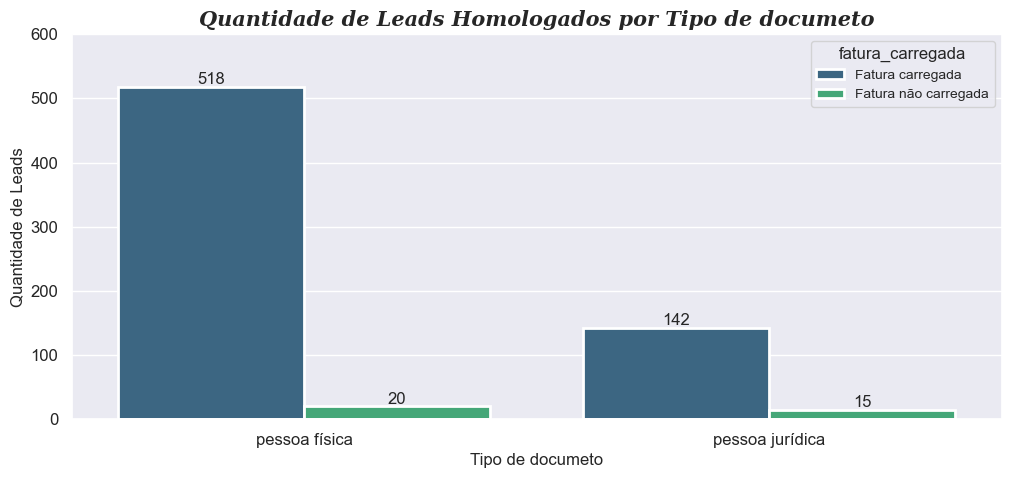

In [53]:
temp_bar = df_analise.where((df_analise['homologado']==1)).groupby(['fatura_carregada'])\
[['billDocumentType']].value_counts().reset_index()

temp_bar.rename(columns={0:'quantidade_de_leads'},inplace=True)
homologado_por_tipo_doc = pd.DataFrame(temp_bar)


fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="billDocumentType", y="quantidade_de_leads",hue='fatura_carregada', data=homologado_por_tipo_doc,linewidth=2, 
            palette='viridis',ax = ax)

ax.set_ylim([0,600])
ax.set_title('Quantidade de Leads Homologados por Tipo de documeto',fontsize = 15, fontweight ='bold',fontstyle ='italic'
             ,fontfamily ='serif')
ax.set_ylabel('Quantidade de Leads',fontsize= 12)
ax.set_xlabel('Tipo de documeto',fontsize= 12)

for i in ax.containers:
    ax.bar_label(i,)


## Existe um desbalanceameto da base, indicando que os dados estão altamente concentrados em Minas Gerais, sendo assim, a análise por estado não adiciona informações que gerem insights úteis

In [54]:
df_analise.groupby(['state'])[['lead_in']].count().reset_index()

,state,lead_in
0,AL,1
1,DF,52
2,ES,1
3,MG,6986
4,MT,1
5,PB,1
6,PE,68
7,PR,2
8,RS,1
9,SC,1


In [55]:
df_analise.where(df_analise['homologado']==1).groupby(['state'])[['homologation_date']].count().reset_index()

,state,homologation_date
0,DF,4
1,MG,689
2,PE,2


In [56]:
df_analise.where(df_analise['homologado']==1).groupby(['billCity'])[['homologation_date']].count().reset_index()

,billCity,homologation_date
0,ALBERTINA,2
1,"ALBERTINA, MG",1
2,ALFENAS,32
3,ALFENAS MG,1
4,"ALFENAS, MG",2
...,...,...
233,VARGINHA MG,1
234,"VICOSA, MG",1
235,divisa nova mg,1
236,monte siao mg,1


In [57]:
df_analise['billCity'].isnull().sum()

3419

# Analisando a coorelação dos dados

In [58]:
funil = df_analise.groupby(['mes','mes_por_extenso'],as_index = False)[['lead_in','bill_uploaded', 'lead_approved_eligible',
       'proposal_sent','contract_signed', 'homologation_date']].count()
funil.rename(columns={'mes_por_extenso':'Mês','lead_in':'Lead','bill_uploaded':'Contas Recebidas', 'lead_approved_eligible':'Contas Elegíveis',
       'proposal_sent':'Propostas Enviadas', 'contract_signed':'Contratos Assinados',
                        'homologation_date':'Contratos Homologados'},inplace = True)
funil

,mes,Mês,Lead,Contas Recebidas,Contas Elegíveis,Propostas Enviadas,Contratos Assinados,Contratos Homologados
0,1,Janeiro,175,79,72,70,22,19
1,2,Fevereiro,116,56,52,51,13,8
2,3,Março,748,452,205,177,72,65
3,4,Abril,899,475,215,190,78,62
4,5,Maio,1303,879,376,338,126,99
5,6,Junho,1443,918,451,304,119,91
6,7,Julho,555,369,260,110,76,62
7,8,Agosto,1889,1629,741,479,338,289


In [59]:
table_a= df_analise.groupby(['mes'],as_index = False)[['lead_in','bill_uploaded', 'lead_approved_eligible',
       'proposal_sent','contract_signed', 'homologation_date','lost_date']].count()

table_a['coversao_percent']= ((table_a['homologation_date']/table_a['lead_in'])*100).round(2)
table_a['contas_recebidas_percent']= ((table_a['bill_uploaded']/table_a['lead_in'])*100).round(2)
table_a['contas_elegiveis_percent']= ((table_a['lead_approved_eligible']/table_a['lead_in'])*100).round(2)
pessoa_fisica_e_juridica = df_analise.groupby(['mes'],as_index = False)[['pessoa física','pessoa jurídica']].sum()

table_a=pd.merge(pessoa_fisica_e_juridica,table_a,on='mes', how = 'outer') 

table_a.rename(columns={'bill_uploaded':'Contas Recebidas', 'lead_approved_eligible':'Contas Elegíveis',
       'proposal_sent':'Propostas Enviadas', 'contract_signed':'Contratos Assinados',
                        'homologation_date':'Contratos Homologados'},inplace = True)
table_a

,mes,pessoa física,pessoa jurídica,lead_in,Contas Recebidas,Contas Elegíveis,Propostas Enviadas,Contratos Assinados,Contratos Homologados,lost_date,coversao_percent,contas_recebidas_percent,contas_elegiveis_percent
0,1,127.0,48.0,175,79,72,70,22,19,156,10.86,45.14,41.14
1,2,55.0,61.0,116,56,52,51,13,8,109,6.90,48.28,44.83
2,3,495.0,253.0,748,452,205,177,72,65,688,8.69,60.43,27.41
3,4,548.0,351.0,899,475,215,190,78,62,845,6.90,52.84,23.92
4,5,916.0,387.0,1303,879,376,338,126,99,1218,7.60,67.46,28.86
5,6,1003.0,440.0,1443,918,451,304,119,91,1263,6.31,63.62,31.25
6,7,316.0,239.0,555,369,260,110,76,62,358,11.17,66.49,46.85
7,8,1414.0,475.0,1889,1629,741,479,338,289,1400,15.30,86.24,39.23


In [60]:
table_a['coversao_percent'].mean()

9.21625

In [61]:
## Como é preciso aumentar nossa taxa de conversão de leads para leads homologados em 30% nos próximos 
# 6 meses para garantir o atingimento da meta, a taxa de conversão média precisa passar a ser de:
table_a['coversao_percent'].mean()*1.3

11.981125

<AxesSubplot:>

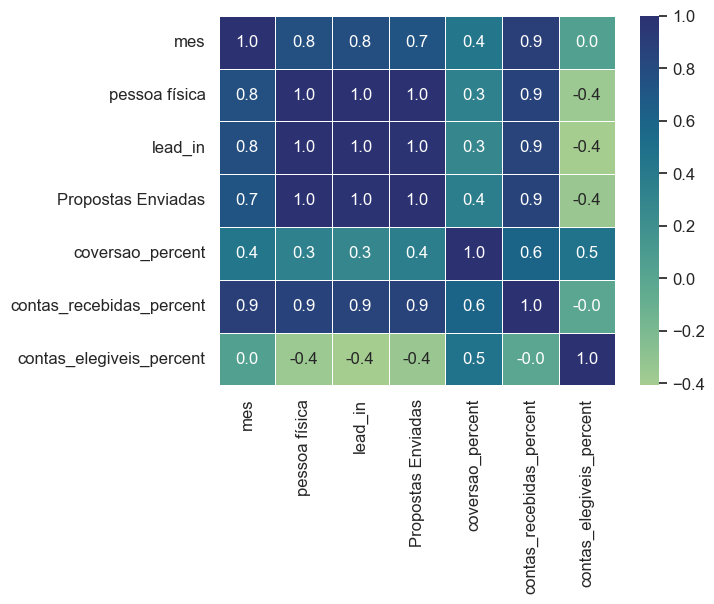

In [62]:
### CUIDADO COM A MULTICOLIEARIEDADE
table_corr = table_a.drop(['Contratos Homologados','pessoa jurídica','Contratos Assinados','Contas Recebidas','lost_date','Contas Elegíveis'], axis = 1)

correlation = table_corr.corr()
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6, cmap = 'crest')
plot

<AxesSubplot:xlabel='Contas Recebidas', ylabel='Contratos Homologados'>

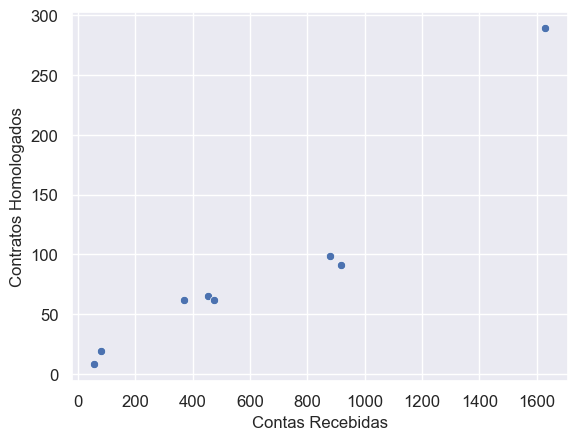

In [63]:
sns.scatterplot(data=table_a,x='Contas Recebidas',y='Contratos Homologados')

<AxesSubplot:xlabel='bill_uploaded', ylabel='homologation_date'>

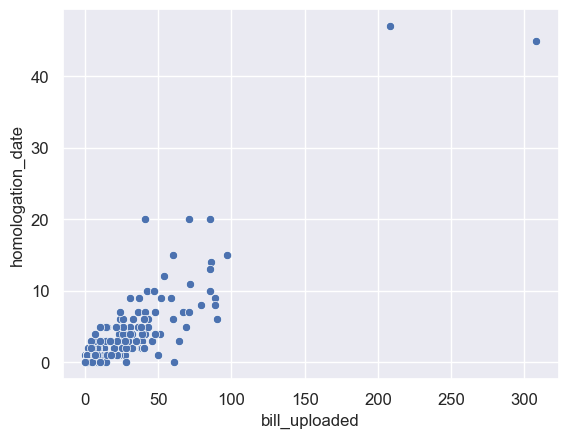

In [64]:
z = df_analise.groupby(['lead_in'],as_index = False)[['bill_uploaded','homologation_date']].count()
sns.scatterplot(data=z,x='bill_uploaded',y='homologation_date')

In [65]:
from statsmodels.tsa.stattools import grangercausalitytests

df = pd.DataFrame(table_a, columns=['contas_recebidas_percent', 'coversao_percent'])

#Aplicando teste de Granger causality
resultados = grangercausalitytests(df, maxlag=2)

print(resultados)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1031  , p=0.7642  , df_denom=4, df_num=1
ssr based chi2 test:   chi2=0.1804  , p=0.6710  , df=1
likelihood ratio test: chi2=0.1782  , p=0.6730  , df=1
parameter F test:         F=0.1031  , p=0.7642  , df_denom=4, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8789  , p=0.3379  , df_denom=1, df_num=2
ssr based chi2 test:   chi2=46.5463 , p=0.0000  , df=2
likelihood ratio test: chi2=13.0196 , p=0.0015  , df=2
parameter F test:         F=3.8789  , p=0.3379  , df_denom=1, df_num=2
{1: ({'ssr_ftest': (0.10311097710931591, 0.7642054173470956, 4.0, 1), 'ssr_chi2test': (0.18044420994130284, 0.6709917711718534, 1), 'lrtest': (0.17815769839658202, 0.6729612891570467, 1), 'params_ftest': (0.10311097710931515, 0.7642054173470966, 4.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002914C278F10>, <statsmodels.regression.linear_model.RegressionResul

In [66]:
df = pd.DataFrame(table_a, columns=['Propostas Enviadas', 'Contratos Homologados'])

#Aplicando teste de Granger causality
resultados = grangercausalitytests(df, maxlag=2)

print(resultados)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5329  , p=0.1003  , df_denom=4, df_num=1
ssr based chi2 test:   chi2=7.9325  , p=0.0049  , df=1
likelihood ratio test: chi2=5.3034  , p=0.0213  , df=1
parameter F test:         F=4.5329  , p=0.1003  , df_denom=4, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1207  , p=0.4368  , df_denom=1, df_num=2
ssr based chi2 test:   chi2=25.4480 , p=0.0000  , df=2
likelihood ratio test: chi2=9.9395  , p=0.0069  , df=2
parameter F test:         F=2.1207  , p=0.4368  , df_denom=1, df_num=2
{1: ({'ssr_ftest': (4.5328755509975505, 0.10031447473998235, 4.0, 1), 'ssr_chi2test': (7.932532214245713, 0.004855380046261, 1), 'lrtest': (5.303424377237178, 0.021283541961988246, 1), 'params_ftest': (4.532875550998176, 0.10031447473996578, 4.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002914A56AFA0>, <statsmodels.regression.linear_model.RegressionResultsWr

In [67]:
## Apesar do R2 Baixo o modelo é apenas para mostrar um resultado preliminarm simples e causal
# Dividindo as variáveis independentes e dependentes

X = table_a[['contas_recebidas_percent']]
y = table_a['coversao_percent']

# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Criando o modelo de regressão linear múltipla
reg = LinearRegression()
reg.fit(X_train, y_train)

# Fazendo previsões
y_pred = reg.predict(X_test)

# Avaliando o desempenho do modelo
r2_score = reg.score(X_test, y_test)
print("R2 Score:", r2_score)
print("Coeficientes: ", reg.coef_)

R2 Score: 0.3432165933245189
Coeficientes:  [0.13499572]
